In [1]:
from tqdm import tqdm, trange
import torch
import torchvision
from PIL import Image, ImageDraw
from torchvision import models
from torch.nn import functional as F
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imagesize
from torch.utils import data
import torch.optim as optim
#from skimage import io, color
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
import os
from pathlib import Path
from torch.utils.data import SubsetRandomSampler,DataLoader,Dataset
import cv2
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
np.random.seed(0)
torch.manual_seed(0)

In [2]:
img_path = 'fold1_seperated_2_classes/test/100X/Malignant/SOB_M_DC-14-11520-100-002.png'
img = Image.open(img_path)

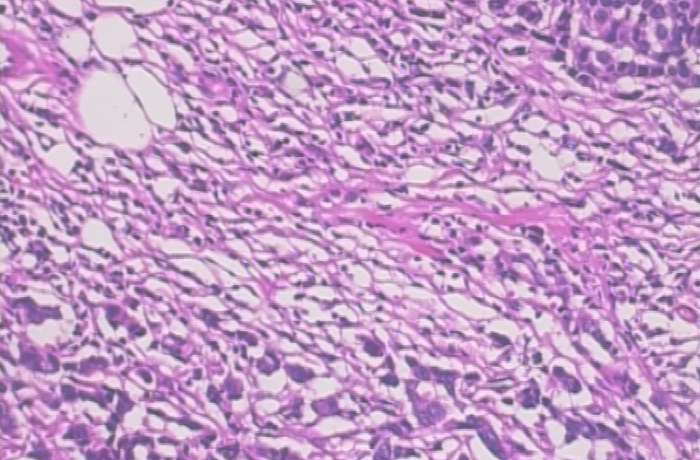

In [3]:
img

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
#data_path = 'BreakHis/fold1_seperated_2_classes/train/40X'
training_dataset_path = 'fold1_seperated_2_classes/train/40X'
testing_dataset_path = 'fold1_seperated_2_classes/test/40X'

In [6]:
def train_transform():
  transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize(
    mean =  [0.8058, 0.6418, 0.7678],
    std = [0.0880, 0.1171, 0.0879])
    ])
  return transform

In [7]:
transform =  train_transform()

In [8]:
X = transform(img).unsqueeze_(0)

In [9]:
def load_dataset(path,transform_img):
  data = torchvision.datasets.ImageFolder(root=path, transform=transform)
  return data

In [10]:
training_dataset = load_dataset(training_dataset_path,transform)
training_dataset

Dataset ImageFolder
    Number of datapoints: 1250
    Root location: fold1_seperated_2_classes/train/40X
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.8058, 0.6418, 0.7678], std=[0.088, 0.1171, 0.0879])
           )

In [11]:
testing_dataset = load_dataset(testing_dataset_path,transform)
testing_dataset

Dataset ImageFolder
    Number of datapoints: 745
    Root location: fold1_seperated_2_classes/test/40X
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.8058, 0.6418, 0.7678], std=[0.088, 0.1171, 0.0879])
           )

In [12]:
train_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 8,shuffle=True)

In [13]:
#Splitting Testing Data into 30% Validation and 70% Testing
dataset_size = len(testing_dataset)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.3 * dataset_size))
train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index]
test_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx) 
test_loader = torch.utils.data.DataLoader(dataset = testing_dataset,batch_size = 8,sampler=test_sampler,shuffle=False)
val_loader = DataLoader(dataset= testing_dataset, shuffle=False, batch_size=8, sampler=val_sampler)

In [14]:
from transformers import SwinConfig, SwinModel
from transformers import AutoImageProcessor, SwinForImageClassification
configuration = SwinConfig()
model = SwinForImageClassification(configuration)

c:\Users\Utkarsh Varman\torch3913\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
model.to(device)

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
  

In [16]:
model(X.to(device))

SwinImageClassifierOutput(loss=None, logits=tensor([[0.2254, 0.7429]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None, reshaped_hidden_states=None)

In [17]:
N_EPOCHS = 150
LR = 0.0001
optimizer = optim.SGD(model.parameters(), lr=LR,momentum=0.9,weight_decay=0.03)
criterion = CrossEntropyLoss()

In [18]:
def set_device():
  if torch.cuda.is_available():
    dev = 'cuda:0'
  else:
    dev = 'cpu'
  return torch.device(dev)

In [19]:
def save_checkpoint(model, epoch, optimizer, best_acc, train_losses, train_acc, val_losses, val_acc):
    state = {
        'epoch': epoch + 1,
        'model': model.state_dict(),
        'best accuracy': best_acc,
        'optimizer': optimizer.state_dict(),
        'train_losses': train_losses,
        'train_acc': train_acc,
        'val_losses': val_losses,
        'val_acc': val_acc
    }
    torch.save(state, 'Models/swin_40X.pth')

In [20]:
def evaluate_model(model,test_loader,criterion):
    model.eval()
    predicted_correctly = 0
    total = 0
    device = set_device()
    running_loss = 0.0

    with torch.no_grad(): 
          for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0) 

            outputs = model(images)

            _,predicted = torch.max(outputs.logits,1)
            loss = criterion(outputs.logits,labels)
            running_loss+=loss.item()

            predicted_correctly+=(predicted==labels).sum().item()
    epoch_acc = 100.0*predicted_correctly/total
    epoch_loss = running_loss/len(test_loader)
    print('-  Testing dataset. Got %d out of %d images correctly (%0.3f%%). Loss: %0.3f' % (predicted_correctly, total, epoch_acc,epoch_loss))

    return epoch_acc,epoch_loss


In [21]:
import numpy as np
import time
import matplotlib.pyplot as plt

def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    best_acc = 0
    train_losses = []
    train_acc = []
    val_acc = []
    val_losses = []
    model = model.to(device)
    
    max_epoch_time = 0.0  # Initialize maximum epoch time
    
    for epoch in range(n_epochs):
        start_time = time.time()  # Start time for current epoch
        
        print("Epoch number: %d" % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()
            outputs = model(images)

            _, predicted = torch.max(outputs.logits, 1)

            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.0 * running_correct / total
        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)

        print("  -Training Dataset, Got %d out of %d images correctly (%0.3f%%). Epoch Loss: %0.3f" % (
        running_correct, total, epoch_acc, epoch_loss))
        
        test_dataset_acc, test_dataset_loss = evaluate_model(model, test_loader, criterion)
        val_acc.append(test_dataset_acc)
        val_losses.append(test_dataset_loss)

        end_time = time.time()  # End time for current epoch
        epoch_time = end_time - start_time
        
        max_epoch_time = max(max_epoch_time, epoch_time)  # Update maximum epoch time
        
        print("Time taken for epoch {}: {:.2f} seconds".format(epoch + 1, epoch_time))

        if(test_dataset_acc>best_acc):
            best_acc = test_dataset_acc
            save_checkpoint(model,epoch,optimizer,best_acc,train_losses, train_acc, val_losses,val_acc)

    print('Finished Training')
    return model, train_losses, train_acc, val_acc, val_losses, max_epoch_time

# Train the model and get the maximum epoch time
model, train_losses, train_acc, val_acc, val_losses, max_epoch_time = train_nn(model, train_loader, val_loader, criterion, optimizer, 50)

Epoch number: 1
  -Training Dataset, Got 1006 out of 1250 images correctly (80.480%). Epoch Loss: 0.487
-  Testing dataset. Got 170 out of 223 images correctly (76.233%). Loss: 0.498
Time taken for epoch 1: 90.53 seconds
Epoch number: 2
  -Training Dataset, Got 1022 out of 1250 images correctly (81.760%). Epoch Loss: 0.441
-  Testing dataset. Got 172 out of 223 images correctly (77.130%). Loss: 0.485
Time taken for epoch 2: 89.68 seconds
Epoch number: 3
  -Training Dataset, Got 1021 out of 1250 images correctly (81.680%). Epoch Loss: 0.442
-  Testing dataset. Got 174 out of 223 images correctly (78.027%). Loss: 0.496
Time taken for epoch 3: 90.13 seconds
Epoch number: 4
  -Training Dataset, Got 1018 out of 1250 images correctly (81.440%). Epoch Loss: 0.432
-  Testing dataset. Got 177 out of 223 images correctly (79.372%). Loss: 0.495
Time taken for epoch 4: 90.32 seconds
Epoch number: 5
  -Training Dataset, Got 1020 out of 1250 images correctly (81.600%). Epoch Loss: 0.432
-  Testing d

In [22]:
model_path = 'Models/swin_40X.pth'
check = torch.load(model_path)

C:\Users\Utkarsh Varman\AppData\Local\Temp\ipykernel_15556\481974279.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check = torch.load(model_path)


In [23]:
check['best accuracy']

83.40807174887892

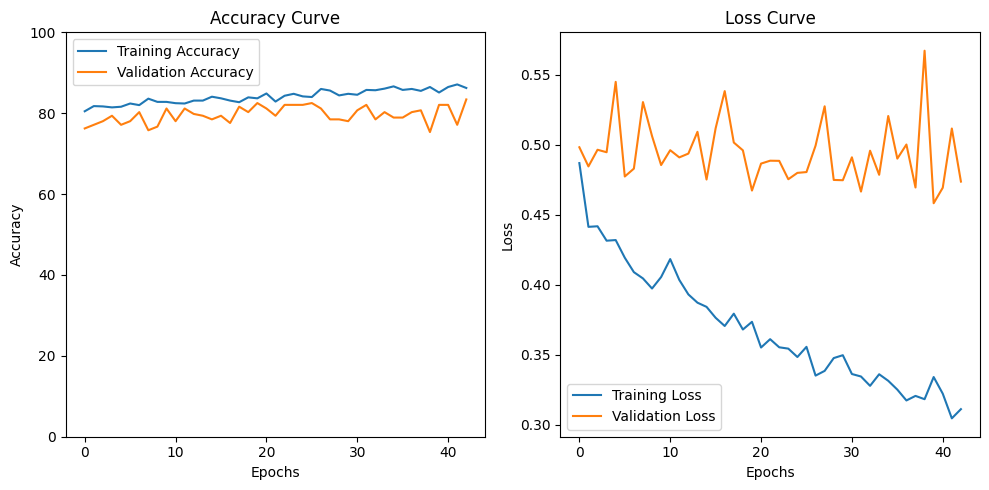

In [24]:
folder_path = 'Graphs/SwinTransformer_40X/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

plt.figure(figsize=(10, 5))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(check['train_acc'], label='Training Accuracy')
plt.plot(check['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.ylim(0, 100)  # Set y-axis limits from 0 to 100 for uniformity
plt.legend()
plt.savefig(os.path.join(folder_path, 'accuracy_curve_swin40X.png'))

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(check['train_losses'], label='Training Loss')
plt.plot(check['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')

plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.savefig(os.path.join(folder_path, 'loss_curve_swin40X.png'))

# Save the figure
plt.tight_layout()
plt.savefig(os.path.join(folder_path, 'training_curves_swin40X.png'))

plt.show()

In [25]:
model.load_state_dict(check['model'])

<All keys matched successfully>

In [28]:
def evaluate_model(model,test_loader,criterion):
    model.eval()
    predicted_correctly = 0
    total = 0
    device = set_device()
    running_loss = 0.0

    with torch.no_grad():
          for data in tqdm(test_loader,desc='Evaluating'):
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            outputs = model(images)

            _,predicted = torch.max(outputs.logits,1)
            loss = criterion(outputs.logits,labels)
            running_loss+=loss.item()

            predicted_correctly+=(predicted==labels).sum().item()
    epoch_acc = 100.0*predicted_correctly/total
    epoch_loss = running_loss/len(test_loader)
    print('-  Testing dataset. Got %d out of %d images correctly (%0.3f%%). Loss: %0.3f' % (predicted_correctly, total, epoch_acc,epoch_loss))

    return epoch_acc,epoch_loss

In [29]:
evaluate_model(model,test_loader,criterion)    

Evaluating: 100%|██████████| 66/66 [00:17<00:00,  3.70it/s]

-  Testing dataset. Got 414 out of 522 images correctly (79.310%). Loss: 0.557


(79.3103448275862, 0.5572160966694355)

In [30]:
def evaluate_model_classification_report(model, test_loader):
    model.eval()
    true_labels = []
    predicted_labels = []
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            true_labels.extend(labels.cpu().numpy())

            outputs = model(images)
            _, predicted = torch.max(outputs.logits, 1)
            predicted_labels.extend(predicted.cpu().numpy())

    return true_labels, predicted_labels
true_labels, predicted_labels = evaluate_model_classification_report(model, test_loader)

In [31]:
from sklearn.metrics import classification_report,roc_auc_score
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.90      0.47      0.62       185
           1       0.77      0.97      0.86       337

    accuracy                           0.79       522
   macro avg       0.83      0.72      0.74       522
weighted avg       0.81      0.79      0.77       522



In [ ]:
auc_score = roc_auc_score(true_labels, predicted_labels)
print("AUC Score:", auc_score)

<h3> Explainability </h3>

In [32]:
img_path = 'fold1_seperated_2_classes/test/40X/Malignant/SOB_M_DC-14-2523-40-012.png'
img = Image.open(img_path) 
img = img.resize((512,512))
img_tensor = transform(img)
#logits = model(X.to(device))

In [33]:
#_,index = torch.max(logits.logits,dim=1)
classes = ['Benign','Malignant']
#print(classes[index])

C:\Users\Utkarsh Varman\AppData\Local\Temp\ipykernel_15556\3597595180.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check = torch.load(model_path)


Predicted Class: Malignant
Class Probabilities:
  Benign: 4.15%
  Malignant: 95.85%


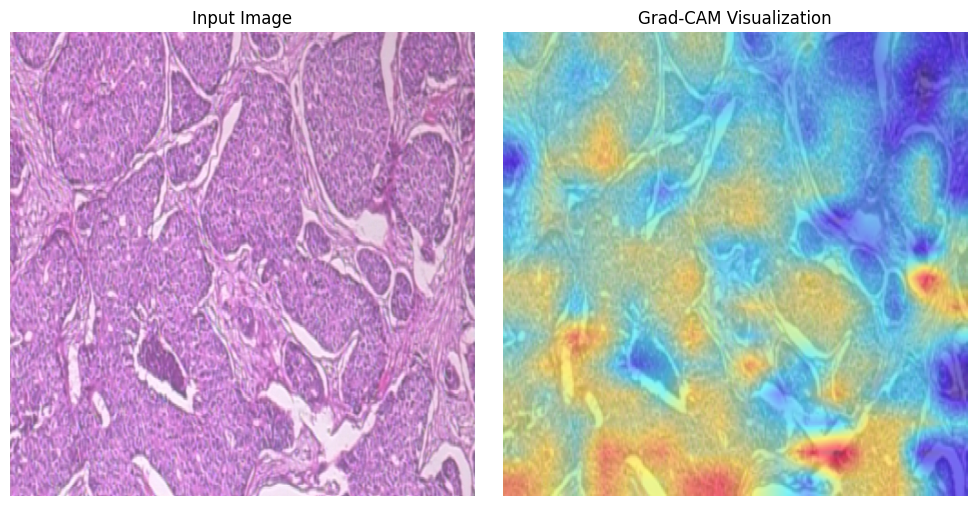

In [34]:
from transformers import SwinForImageClassification
from transformers import SwinConfig
from functools import partial
from typing import List, Callable, Optional
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GradCAM


def swinT_reshape_transform_huggingface(tensor, width, height):
    result = tensor.reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

CATEGORY_NAMES = ["Benign", "Malignant"]

def category_name_to_index(model, category_name):
    return CATEGORY_NAMES.index(category_name)

class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        if len(model_output.shape) == 1:
            return model_output[self.category]
        return model_output[:, self.category]


def print_top_categories_with_softmax(model, img_tensor):
    logits = model(img_tensor.unsqueeze(0)).logits
    
    probabilities = torch.nn.functional.softmax(logits, dim=1)[0]
    
    max_index = torch.argmax(probabilities).item()
    predicted_category = CATEGORY_NAMES[max_index]
    predicted_probability = probabilities[max_index].item() * 100  # Convert to percentage
    
    print(f"Predicted Class: {predicted_category}")
    print("Class Probabilities:")
    for idx, category in enumerate(CATEGORY_NAMES):
        print(f"  {category}: {probabilities[idx].item() * 100:.2f}%")
    
    return max_index, predicted_probability


configuration = SwinConfig()
model = SwinForImageClassification(configuration)
model_path = 'Models/swin_40X.pth'
check = torch.load(model_path)
model.load_state_dict(check['model'])
model.eval()


target_layer = model.swin.layernorm
reshape_transform = partial(swinT_reshape_transform_huggingface, 
                            width=img_tensor.shape[2] // 32, 
                            height=img_tensor.shape[1] // 32)


class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits


def run_grad_cam_on_top_category(model: torch.nn.Module,
                                 target_layer: torch.nn.Module,
                                 img_tensor: torch.Tensor,
                                 img: Image,
                                 max_index: int,
                                 reshape_transform: Optional[Callable],
                                 method: Callable = GradCAM):
  
    target = [ClassifierOutputTarget(max_index)]
    with method(model=HuggingfaceToTensorModelWrapper(model),
                target_layers=[target_layer],
                reshape_transform=reshape_transform) as cam:
        grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0), targets=target)[0]
        
        # Create visualization
        visualization = show_cam_on_image(np.float32(img) / 255, grayscale_cam, use_rgb=True)
        visualization = cv2.resize(visualization, (visualization.shape[1] // 2, visualization.shape[0] // 2))
        return visualization

def save_image_opencv(image: np.ndarray, save_path: str):
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, image_bgr)
    print(f"Image saved to {save_path}")

def display_image_opencv(image: np.ndarray, display_time=10000):
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imshow("Grad-CAM Output", image_bgr)
    cv2.waitKey(display_time) 
    cv2.destroyAllWindows()

def plot_images(input_image: np.ndarray, gradcam_image: np.ndarray):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].imshow(input_image.astype(np.uint8))  
    ax[0].set_title("Input Image")
    ax[0].axis("off")
    
    ax[1].imshow(gradcam_image)
    ax[1].set_title("Grad-CAM Visualization")
    ax[1].axis("off")
    
    plt.tight_layout()
    plt.show()



max_index, top_probability = print_top_categories_with_softmax(model, img_tensor)


gradcam_image = run_grad_cam_on_top_category(model=model,
                                             target_layer=target_layer,
                                             img_tensor=img_tensor,
                                             img=img,
                                             max_index=max_index,
                                             reshape_transform=reshape_transform)


save_path = "gradcam_output_cv2.png"
#save_image_opencv(gradcam_image, save_path)

#display_image_opencv(gradcam_image, display_time=10000)

# Display the image as a figure using matplotlib
input_image_np = np.array(img) 
plot_images(input_image_np, gradcam_image)
